# Project 2 - Ames Housing Data

## Model Optimization

*Author: Grace Campbell*

> - Previous Notebook: [Feature Engineering and Model Selection](Project-2-Feature-Engineering.ipynb)
___

In [113]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

df = pd.read_csv('./datasets/train_cleaned.csv', keep_default_na=False).drop(
    ['Unnamed: 0', 'Misc Val', 'Pool Area', 'Pool QC'], axis=1)
df_test = pd.read_csv('./datasets/test_cleaned.csv', keep_default_na=False).drop(
    ['Unnamed: 0', 'Id', 'PID', 'Misc Val', 'Pool Area', 'Pool QC'], axis=1)

In [114]:
# Creating dummy columns for chosen categorical variables
cat_variables = ['Neighborhood', 'Exterior 1st', 'Condition 1', 'Foundation', 'Sale Type']
df = pd.get_dummies(df, columns=cat_variables, drop_first=True)
df_test = pd.get_dummies(df_test, columns=cat_variables, drop_first=True)

# Making the datasets only those columns with numeric data
df = df._get_numeric_data()
df_test = df_test._get_numeric_data()

# Making sure both datasets share the same dummy columns
train_features = [col for col in df.columns if col in df_test.columns]
test_features = [col for col in df_test.columns if col in df.columns]

# Defining X and y for training set
X = df[train_features] 
y = df['SalePrice']

# Log transforming y
y_log = np.log(y)

# Defining X for test set
test_X = df_test[test_features]

# Train-test-splitting
X_train, X_test, y_train, y_test = train_test_split(X, y_log, random_state=42)

In [66]:
# Creating a Pipeline
pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('lcv', LassoCV(0.00418)),
])

In [67]:
# Fitting the Pipeline to the training data
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lcv', LassoCV(alphas=None, copy_X=True, cv=None, eps=0.00418, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

In [100]:
# Scoring the model on the test set
pipe.score(X_test, y_test)

0.838317456726213

My final model has an $R^2$ score of 0.839, which means about ~84% of the variance in the data can be explained by my model compared to the null model.

### Residual Analysis

In [101]:
y_pred = pipe.predict(X_test)

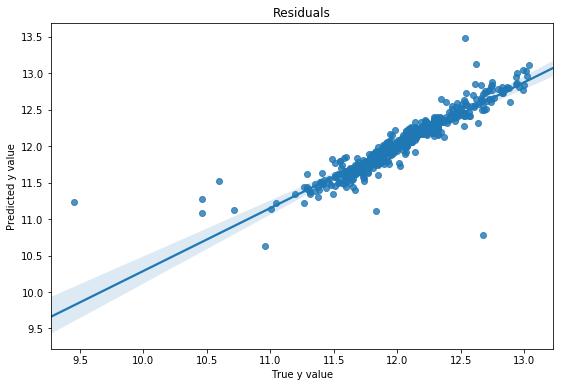

In [102]:
plt.figure(figsize=(9, 6))
ax = sns.regplot(x=y_test, y=y_pred)
ax.set_xlabel('True y value')
ax.set_ylabel('Predicted y value')
ax.set_title('Residuals');

The residuals appear to have a linear relationship, which means my model is doing its job.

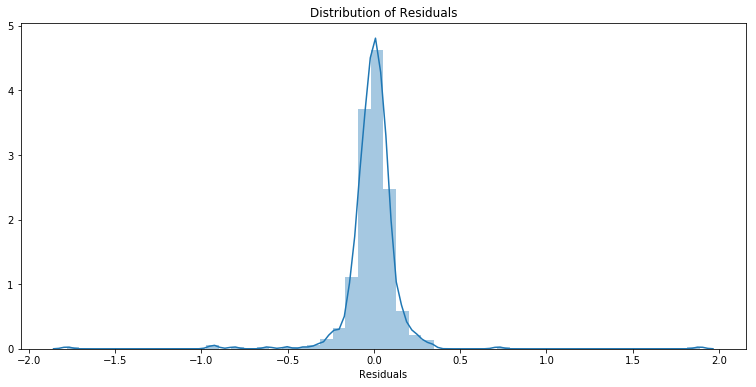

In [103]:
residuals = y_test - y_pred

plt.figure(figsize=(13, 6))
ax = sns.distplot(residuals)
ax.set_xlabel('Residuals')
ax.set_title('Distribution of Residuals');

The residuals follow an approximately normal distribution. The residuals have a high spike around 0 because I performed a log transformation on the `y` variable, so these residuals are naturally smaller. There appear to be some outliers, so I will check this with a boxplot:

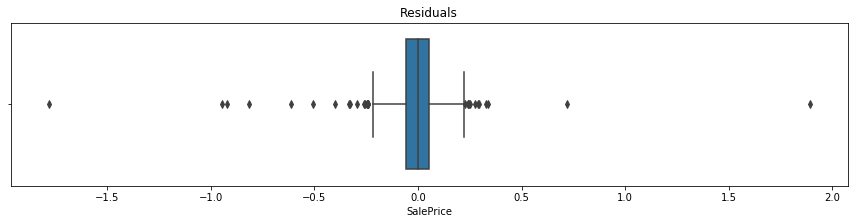

In [104]:
plt.figure(figsize=(15, 3))
ax = sns.boxplot(residuals)
ax.set_title('Residuals');

There appear to be quite a few outliers in the residuals; however, given the large number of data points, the overall model score, and the distribution of the residuals, I am not concerned about the outliers.

## Submitting Predictions to Kaggle

In [105]:
from datetime import datetime

In [110]:
test_preds = np.exp(pipe.predict(test_X))

In [111]:
timestamp = str(datetime.now()).split(':')[0]

df_test = pd.read_csv('./datasets/test_cleaned.csv')
to_submit = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': test_preds})
to_submit.to_csv(f'my_submission_{timestamp}.csv', index=False)

____